In [1]:
import configparser


from PIL import Image
import io
import os
import numpy as np

import boto3

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
from pyspark.sql.functions import udf

# Taches machine learning
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt

In [2]:
aws_profile = "default"

config = configparser.ConfigParser()
config.read(os.path.expanduser(".aws/credentials"))
access_id = config.get(aws_profile, "aws_access_key_id".upper()) 
access_key = config.get(aws_profile, "aws_secret_access_key".upper())

In [3]:
session = boto3.Session(
    aws_access_key_id=access_id,
    aws_secret_access_key=access_key,
)

In [4]:
s3 = session.resource('s3')
bucket = s3.Bucket("fruits-oc-p08")
obj = bucket.Object(key='sample/apple_golden_1/r0_107.jpg')
response = obj.get()
file_stream = response[u'Body']
im = Image.open(file_stream)
im = im.resize((20,20))
im_arr = np.asarray(im)

In [5]:
im

In [6]:
paths = []
for file in bucket.objects.all():
    paths.append(file.key)
    
rdd_paths = sc.parallelize(paths)
row_rdd_paths = rdd_paths.map(lambda x: Row(x))

In [7]:
images_df = spark.createDataFrame(row_rdd_paths, ['path'])

In [8]:
# images_df.show(6)

In [9]:
def get_categ(path):
    folder_name = path.split('/')[1]
    categ = folder_name.split('_1')[0]
    return categ

In [10]:
udf_categ = udf(get_categ, StringType())
images_df = images_df.withColumn('categ', udf_categ('path'))

In [11]:
images_df.show(6, truncate=60)

+---------------------------------+-------------+
|                             path|        categ|
+---------------------------------+-------------+
| sample/apple_golden_1/r0_107.jpg| apple_golden|
| sample/apple_golden_1/r0_171.jpg| apple_golden|
| sample/apple_golden_1/r1_147.jpg| apple_golden|
| sample/apple_golden_1/r1_175.jpg| apple_golden|
| sample/apple_golden_1/r1_239.jpg| apple_golden|
|sample/cabbage_white_1/r0_139.jpg|cabbage_white|
+---------------------------------+-------------+
only showing top 6 rows



In [12]:
def get_image(path):
    s3 = session.resource('s3')
    bucket = s3.Bucket("fruits-oc-p08")
    obj = bucket.Object(key=path)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    im_resized = im.resize((20, 20))
    return np.array(im_resized).flatten().tolist()

In [13]:
len(get_image('sample/apple_golden_1/r0_107.jpg'))

1200

In [14]:
udf_image = udf(get_image)

In [15]:
images_df = images_df.withColumn('data', udf_image('path'))

In [16]:
images_df.show(6, truncate=60)

+---------------------------------+-------------+------------------------------------------------------------+
|                             path|        categ|                                                        data|
+---------------------------------+-------------+------------------------------------------------------------+
| sample/apple_golden_1/r0_107.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r0_171.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_147.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_175.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_239.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
|sample/cabbage_white_1/r0_139.jpg|cabbage_white|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
+

In [17]:
# conversion format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
images_df = images_df.withColumn('data', ud_f('data'))

In [18]:
#standardisation des données
standardizer = StandardScaler(inputCol="data", outputCol="data_scale", withStd=True, withMean=True)
model_std = standardizer.fit(images_df)
images_df = model_std.transform(images_df)

In [19]:
images_df.show(6)

+--------------------+-------------+--------------------+--------------------+
|                path|        categ|                data|          data_scale|
+--------------------+-------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/cabbage_wh...|cabbage_white|[255.0,255.0,255....|[0.29727137307215...|
+--------------------+-------------+--------------------+--------------------+
only showing top 6 rows



In [20]:
pca_obj = PCA(k=100, inputCol='data_scale')
pca_model = pca_obj.fit(images_df)

Text(0, 0.5, 'Variance cumulée')

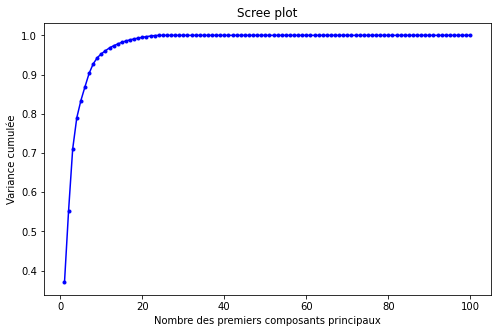

In [21]:
eVc = pca_model.explainedVariance.cumsum()
#plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8,5))
plt.plot(range(1,len(eVc)+1), eVc, color='b',
         marker = '.', linestyle='-')
plt.title('Scree plot')
plt.xlabel('Nombre des premiers composants principaux')
plt.ylabel('Variance cumulée')

In [22]:
pca_obj = PCA(k=20, inputCol='data_scale', outputCol='pca_features')
pca_model = pca_obj.fit(images_df)

In [23]:
images_df = pca_model.transform(images_df)

In [24]:
images_df.show(6)

+--------------------+-------------+--------------------+--------------------+--------------------+
|                path|        categ|                data|          data_scale|        pca_features|
+--------------------+-------------+--------------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|[4.98322515727135...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|[9.61064370313451...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|[6.13758904996988...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|[7.46652431865648...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|[8.93427882146846...|
|sample/cabbage_wh...|cabbage_white|[255.0,255.0,255....|[0.29727137307215...|[6.35674010172881...|
+--------------------+-------------+--------------------+--------------------+--------------------+
